In [50]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [29]:
TRAIN_DATA_PATH = "./data/train.csv"
TEST_DATA_PATH = "./data/test.csv"

full_df = pd.read_csv(TRAIN_DATA_PATH, index_col="Id")
X_test = pd.read_csv(TEST_DATA_PATH, index_col="Id")

In [30]:
full_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [31]:
# Setting target and feature columns
y = full_df.SalePrice
full_df.drop('SalePrice', axis=1, inplace=True)

In [32]:
num_cols = full_df.select_dtypes(exclude='object').columns.to_list()
# choosing categorical columns that have less than 10 cardinality
categorical_cols = [cname for cname in full_df.columns
                    if full_df[cname].dtypes == "object" and full_df[cname].nunique() <=10]

feature_cols = categorical_cols + num_cols
print(f"Number of categorical columns:{len(categorical_cols)}")
print(f"Number of numerical columns:{len(num_cols)}")
print(f"Number of total features to be used for training: {len(feature_cols)}")

Number of categorical columns:40
Number of numerical columns:36
Number of total features to be used for training: 76


In [33]:
#setting the df with the selected features
X_train_full = full_df[feature_cols].copy()
X_test_f = X_test[feature_cols].copy()  

In [34]:
# training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y,test_size=0.2, random_state=1)
print(f"Shape of features {X_train.shape}")

Shape of features (1168, 76)


# Building Pipeline

In [35]:
# for numerical columns
num_transformer = SimpleImputer(strategy="mean")
# for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', categorical_transformer, categorical_cols)
])

my_model = RandomForestRegressor(n_estimators=100, random_state=1)

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', my_model)
    ])


## Training the model and evaluation

In [36]:
my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond',

In [37]:
predictions = my_pipeline.predict(X_valid)
mae = mean_absolute_error(y_valid, predictions)
print(f"Mean Absolute Error {mae:0.2f}")

Mean Absolute Error 16447.12


In [38]:
my_pipeline.predict(X_test)

/Users/spydermac/opt/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([130555.5 , 154640.25, 179534.32, ..., 150011.09, 121966.5 ,
       226474.79])

In [13]:
test_pred = my_pipeline.predict(X_test_f)

In [16]:
submission_df = pd.DataFrame({"id":X_test_f.index,
                              "SalePrice": test_pred})
submission_df

,id,SalePrice
0,1461,130555.50
1,1462,154640.25
2,1463,179534.32
3,1464,181399.50
4,1465,198449.12
...,...,...
1454,2915,85617.50
1455,2916,85916.00
1456,2917,150011.09
1457,2918,121966.50


In [18]:
submission_df.to_csv("./data/submission2.csv", index=False)

# Cross-Validation

In [25]:
from sklearn.model_selection import cross_val_score

In [39]:
X = full_df[feature_cols].copy()

In [40]:
mae_cross_val = -1 * cross_val_score(my_pipeline, X, y,
                                     cv=5,
                                     scoring="neg_mean_absolute_error")

In [43]:
(mae_cross_val.mean())

17723.82826027397

## Find the best Hyperparams

In [73]:

def get_scores(n_estimators):
    """A function that passes a hyper parameter, and calculates the average of MAEs

    Args:
        n_estimators (int): range(50,401, 50), from 50 to 400 with a step of 50
    """
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=1)
    # using the same pipeline as before
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
        ])
    # multiply by -1 as cross_val uses negative mean absolute errors
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')
    print(f"n_estimators ==> {n_estimators}")
    print(f"\t Average MAE: {scores.mean()}")
    return scores.mean()
    

In [74]:
# a dictionary of results 

results = {i: get_scores(i) for i in range(50, 401, 50)}
print(results)

n_estimators ==> 50
	 Average MAE: 18346.222891812642
n_estimators ==> 100
	 Average MAE: 18089.393534869574
n_estimators ==> 150
	 Average MAE: 17990.611618327075
n_estimators ==> 200
	 Average MAE: 17963.50684792957
n_estimators ==> 250
	 Average MAE: 17946.293769119184
n_estimators ==> 300
	 Average MAE: 17938.41976532976
n_estimators ==> 350
	 Average MAE: 17940.68985977166
n_estimators ==> 400
	 Average MAE: 17937.779773169623
{50: 18346.222891812642, 100: 18089.393534869574, 150: 17990.611618327075, 200: 17963.50684792957, 250: 17946.293769119184, 300: 17938.41976532976, 350: 17940.68985977166, 400: 17937.779773169623}


In [59]:
list(results.keys())

[50, 100, 150, 200, 250, 300, 350, 400]

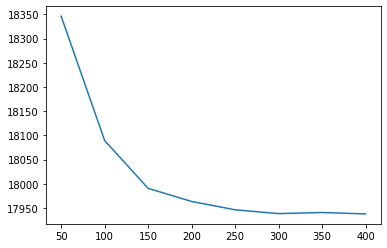

In [76]:
x_values = list(results.keys())
y_values = list(results.values())
plt.plot(x_values, y_values,'-')
#plt.ylim(bottom=min(y_values), top=max(y_values))

## Best Model

In [83]:
best_n_estimator = min(results, key=results.get)
print(f"The best number of estimators is {best_n_estimator}")

The best number of estimators is 400
